In [10]:
import arch
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import statsmodels.api as sm
import warnings
import yfinance as yf
from datetime import date, datetime, timedelta
from operator import itemgetter
from sklearn.metrics import confusion_matrix
from typing import List, Tuple

from etl.load_volatility import get_data_with_vix
from indicators.transform import build_features
from indicators.temporal_features import difference_features


sns.set_style("darkgrid")

In [53]:
# EIA Weekly Report of oil storage inventory
storage_data_fp = "data/weekly_us_crude_stocks.xls"

storage_df = pd.read_excel(storage_data_fp, sheet_name="Data 1", skiprows=[0, 1])
storage_df.rename(columns={"Date": "date", storage_df.columns[1]: "oil_stock"}, inplace=True, errors="raise")

storage_df.set_index("date", inplace=True)
storage_df.index = pd.to_datetime(storage_df.index)

# Price and Volatility Data
ticker = "CL=F"
vix = "^OVX"
interval = "1d"
end_date = date.today()
start_date = datetime.strptime("2017-01-01", "%Y-%m-%d")

df = get_data_with_vix(ticker, vix=vix, start_date=start_date, end_date=end_date, interval=interval)

# Use flat stoarge across the week.
# df = df.join(storage_df)
# df["oil_stock"].fillna(method="ffill", inplace=True)

# df["diff_oil_stock"] = df["oil_stock"].diff(periods=1)
# df.dropna(inplace=True)

# features, target = build_features(
#     df,
#     features_cols=["price", "volume", "vix", "diff_oil_stock"],
#     add_lag_features={"price": [1, 2, 3, 7], "vix": [1, 2, 3, 7], "oil_stock": [7]},
#     add_yearly_features=True,
# )

print(f"df: {df.shape}, features: {features.shape}, target: {target.shape}")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
df: (1547, 3), features: (1535, 16), target: (1535,)


In [54]:
# Groupby: [week of the year, year]. Easy to change to month if needed.
df["day_of_week"] = df.index.day_of_week

# ARIMA Model

In [60]:
# Test for Stationarity - ADF Test.
is_stationary = adf_stationarity(df["price"], trend="c")
print(f"price stationary = {is_stationary}")

# Perform differencing until stationary.
periods = 1
df[f"price_diff_{periods}"] = df["price"].diff(periods=periods)
df.dropna(inplace=True)

is_stationary = adf_stationarity(df["price_diff_1"], trend="c")
print(f"price diff 1 stationary = {is_stationary}")

price stationary = False
price diff 1 stationary = True


In [64]:
# Number of lags to trial.
lags = 252

conf_interval = {95: 0.05}
alpha = conf_interval[95]

acf, conf = sm.tsa.stattools.acf(x=df["price"], nlags=lags, alpha=alpha)

# Centre the confidence boundaries on the data.
conf_centred = conf - np.expand_dims(acf, axis=-1)

# Significant data: outside of the blue bands (above or below).
sig_data = np.abs(acf) >= conf_centred[:, 1]

# Largest lag of raw (non-differenced) price data.
max_lag = max(index for index, value in enumerate(sig_data) if value)
max_lag

110

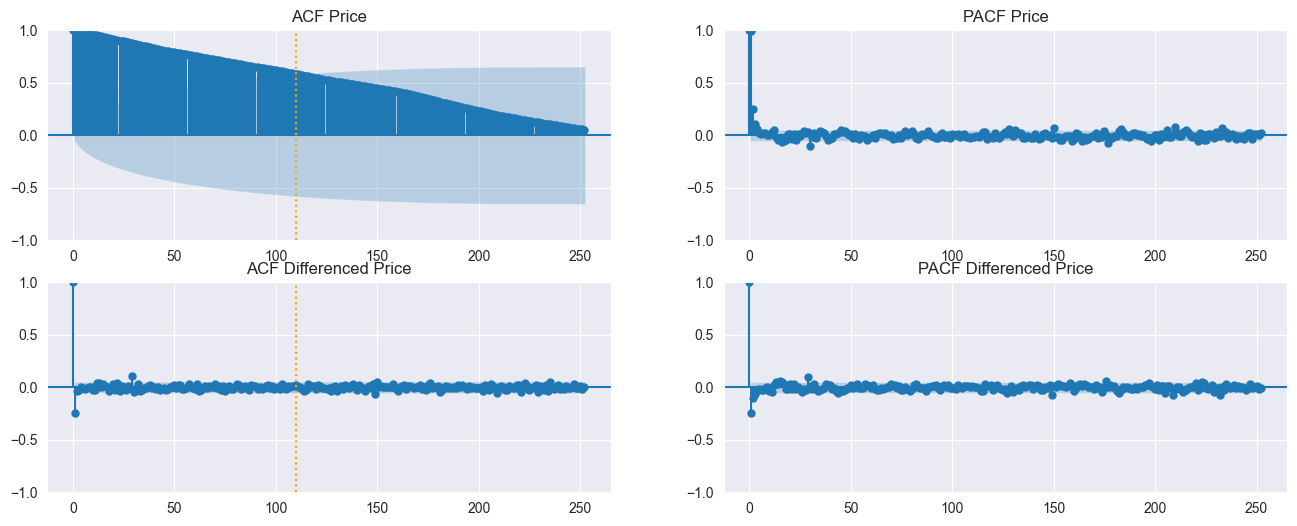

In [65]:
# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price"]

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(221)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Price")

ax2 = fig.add_subplot(222)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF Price")

# NOTE: the blue bands are the error bands - anything within them is not statistically significant.
x = df["price_diff_1"]

ax3 = fig.add_subplot(223)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax3)
plt.vlines(max_lag, ymin=-1.0, ymax=1.0, color="orange", linestyle="dotted")
plt.title("ACF Differenced Price")

ax4 = fig.add_subplot(224)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax4)
plt.title("PACF Differenced Price")

plt.show()

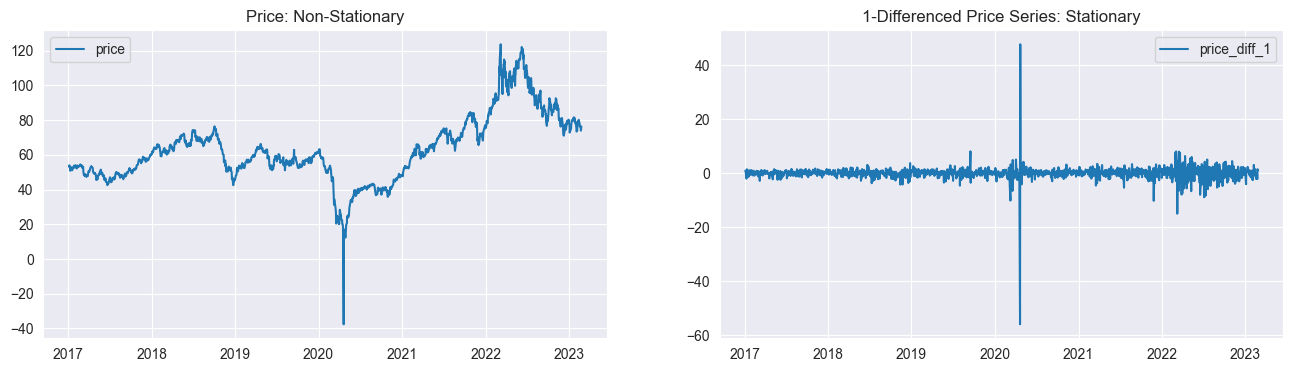

In [66]:
fig = plt.figure()
fig.set_size_inches(16, 4)

# Price.
plt.subplot(1, 2, 1)
plt.title("Price: Non-Stationary")
plt.plot(df["price"], label="price")
plt.legend()

# Differenced Price.
plt.subplot(1, 2, 2)
plt.title("1-Differenced Price Series: Stationary")
plt.plot(df["price_diff_1"], label="price_diff_1")
plt.legend()

plt.show()

In [67]:
# ARMA requires stationarity - once stationary, determine form of ARMA(p,q) model via the ACF and PACF functions for each series.
# lags = 10
max_lags = 10

# ACF: correlation coefficient with each lag.
acf = sm.tsa.stattools.acf(x=df["price_diff_1"], nlags=lags)

# PACF: direct correlation of signal s_t with lag s_{t-k}, controlling for the effects of other variables, e.g. mutual correlations with other s_{t-i}.
pacf = sm.tsa.stattools.pacf(x=df["price_diff_1"], nlags=lags)

print(acf.shape, pacf.shape)

# Confidence interval is 95% by default.
indices = np.where(pacf > 0.05)
indices, pacf[indices]

(253,) (253,)


((array([  0,  13,  15,  29, 176]),),
 array([1.        , 0.05156972, 0.05651203, 0.0980941 , 0.05844189]))

In [68]:
from algo.forecasting.arima_multiprocessing import arima_parallel

In [69]:
p_candidates = range(max_lag)
d_candidates = (0,)
q_candidates = range(max_lag)

out = arima_parallel(
    p_candidates,
    d_candidates,
    q_candidates,
    data=df["price_diff_1"].values,
    num_processes=8,
)

KeyboardInterrupt: 

In [26]:
gr = df.groupby(by=[df.index.isocalendar().year, df.index.isocalendar().week])

# Number of samples in weeks.
num_samples = len(gr)
num_samples

In [43]:
# Number of samples in days.
num_samples = len(df)
num_train_initial = int(num_samples / 2)

767

In [50]:
start_test_index = num_train_initial + 1
print(f"Start Test: {start_test_index}")

# Move the start of the test to the nearest Monday after enough data is used for initial training.
while df.loc[df.index[start_test_index]].day_of_week != 0.0:
    start_test_index +=1
    
    if start_test_index > len(df):
        # Fail safe.
        break

print(f"Start Test Adj: {start_test_index}")

Start Test: 768
Start Test Adj: 769


# Serial Autocorrelation in Errors (Residuals) - ARCH Effects

In [ ]:
# High p-value (-> 1) indicates residuals are not autocorrelated.
lb_resid_df = sm.stats.acorr_ljungbox(x=arima_model.resid, lags=[p_opt, q_opt])
lb_resid_df

In [ ]:
# Small p-value for squared-residuals indicates ARCH effects in residuals.
lb_resid_sq_df = sm.stats.acorr_ljungbox(x=np.square(arima_model.resid), lags=[p_opt, q_opt])
lb_resid_sq_df

In [ ]:
# Use PACF to assess order of ARCH model.
x = np.square(arima_model.resid)

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
plt.title("ACF for squared ARMA residuals")
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
plt.title("PACF for squared ARMA residuals")